##### In this project, I will be using transfer learning to train on a bee and ants dataset using the Resnet18 Convolutional Neural Network which was initially trained on more than a million images on the image net database. It is 18 layers deep and can classify images into 1000 object categories. But i will be using it for just BEEs and ANTs images

In [1]:
import torch
import torchvision

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

##### since the mean and standard deviation values for the RGB channels of the IMAGENET dataset are typically pre-calculated and widely accepted, I did not need to calculate the mean of the dataset

In [20]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [21]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256), #Did this to resize the image to 256 pixels on the shorter side.
        transforms.CenterCrop(224), # to crop the center of each image (224 x 224)
        transforms.ToTensor(), # to  convert the images to the "pytorch tensor" form
        transforms.Normalize(mean, std) # to normalize the image using the predefined mean and standard deviation
    ]),
}

In [22]:
data_path = '/workspaces/Transfer_learning_with_resnet/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_path, x), data_transforms[x])
for x in ['train', 'val']}  #applying transformations to images


In [23]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
                                             for x in ['train', 'val']}
                                            
dataset_sizes = {x:len(image_datasets[x]) for x in ['train', 'val']} # to create dict to show number of samples in respectve datasets

class_names = image_datasets['train'].classes # to retrive class names from the training data (Bees and Ants)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)


['ants', 'bees']


In [24]:
# now I will create a fuction using the popular imshow fuctio that reads images
def imshow(inp, title):
    inp = inp.numpy().transpose((1, 2, 0)) # to convert tensor to np array and rearrange dimensions for matplotlib
    inp = std * inp + mean # the image was normalized earlied, matplotlib need it denormalized
    inp = np.clip(inp, 0, 1) #values must be between 1 and 0
    plt.imshow(inp)
    plt.title(title)
    plt.show(title)

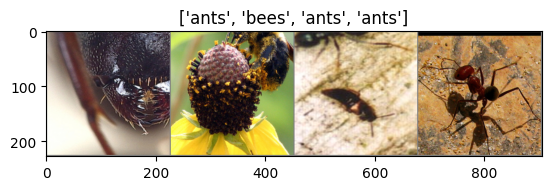

In [25]:
inputs, classes = next(iter(dataloaders['train']))#to gets the next batch of images and corresponding class labels from the training data

out = torchvision.utils.make_grid(inputs) #rearranging the individual input images into a rectangular shape, stacking them row by row.

imshow(out, title=[class_names[x] for x in classes])

#### phew, now to write a function to train the model

I will go through the route of writing a fuction **"train_model()"** which I will used to train the model for a specified number of epochs.

The fuction will also perform training and validation phases for each epoch, compute the **loss and accuracy**, and **update** the model parameters during training.


The model with the best validation accuracy was saved and returned at the end of training.

In [36]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time() #to return the current time since the first epoch to know total training time

    best_model_wts = copy.deepcopy(model.state_dict()) # to get a copy of the weights as the validation takes place
    best_acc = 0.0 # for tracking best weights by initializing the best accuracy

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        #OK now
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval() 

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]: # to go over the batches in the train and val
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                with torch.set_grad_enabled(phase == 'train'): # to set gradient tracking only in training phaser
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # the class with the highest output is the image the model thinks at that time is the right image it is "looking at"
                    loss = criterion(outputs, labels) # computes the loss by comparing this output with the actual labels of that image

                    # now, we do a backward propagation
                    if phase == 'train':
                        optimizer.zero_grad() # clears previous gradients to avoid accumulation
                        loss.backward()          # computes new gradients from the loss
                        optimizer.step()            # updates the model's parameters based on new grads
                
                running_loss += loss.item() * inputs.size(0) # multiplies the loss by batchsize to get total loss
                running_corrects += torch.sum(preds == labels.data) #counts the number of correct predicions

            if phase == 'train':
                scheduler.step() # this is to adjust the learning rate if necessary
            epoch_loss = running_loss / dataset_sizes[phase] #to compute the average loss for the current epoch by dividing the accumulated loss by the total number of samples in the dataset.
            epoch_acc = running_corrects.double() / dataset_sizes[phase] #to compute the average accuracy by dividing the number of correct predictions by the total number of samples in the dataset.

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))       

            if phase == 'val' and epoch_acc > best_acc: # update the best accuracy if it is better
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

##### The convolutional neural network model has been trained, now we go on to transfer learning using resnet18


In [37]:
model = models.resnet18(pretrained=True) #Loading the reset pretrained model .
num_ftrs = model.fc.in_features #to get number of input features from the last (fc) layer

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

/home/codespace/.python/current/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/24
----------
train Loss: 0.6826 Acc: 0.6025
val Loss: 0.4602 Acc: 0.8366

Epoch 1/24
----------
train Loss: 0.5752 Acc: 0.6844
val Loss: 0.3492 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.4817 Acc: 0.8033
val Loss: 0.2905 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.4414 Acc: 0.7951
val Loss: 0.2514 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.4266 Acc: 0.8156
val Loss: 0.2291 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.4156 Acc: 0.8156
val Loss: 0.2184 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.3584 Acc: 0.8443
val Loss: 0.2029 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3008 Acc: 0.8893
val Loss: 0.2049 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3757 Acc: 0.8361
val Loss: 0.1983 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3143 Acc: 0.8770
val Loss: 0.1964 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3182 Acc: 0.8730
val Loss: 0.1963 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3522 Acc: 0.8402
val Loss: 0.1914 Acc: 0.9412

Ep